# What's the optimal percentage of my portfolio to keep invested in SQ?

In [1]:
from requests import Session
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams

# Inputs

In [2]:
'''
Cost basis
'''
COST_BASIS = 5.26
'''
Average Tax Rate on Long Term Capital Gains
'''
TAX_RATE = 0.238 + 0.093
'''
Opportunity cost of capital, assumed to be 5% per year after tax
'''
OPP_COST = 1.05 ** 3.0 - 1.0
'''
Per-share EV of Square in a Worst Case scenario (exclude risk of ruin / bankruptcy—we'll address that separately)
'''
EV_WORST = 9
'''
Probability of that Worst Case actually happening
'''
P_WORST = 0.1
'''
+/- P_WORST error bounds for the chart below
'''
P_WORST_ERROR = P_WORST * 0.5
'''
Per-share NPV of SQ EV in 3 years assuming the Worst Case is impossible
'''
EV_GOOD = 20.00 / (1 + OPP_COST)
'''
Cumulative probability of ruin for SQ over your holding period.
Ruin means the stock is worth $0. A conservative but reasonable
estimate is 0.6% per year[1] multiplied by the number of years you
are willing to hold, for example three years.

1. B (junk bond) "Financials" default rates have a 5-year average
    of 0.6% per year. (https://www.nact.org/resources/2014_SP_Global_Corporate_Default_Study.pdf,
    page 38). We comparing SQ common stock to a junk bond.
'''
P_RUIN = 1.0 - pow(1.0-0.006, 3.0)
'''
EV excluding the possibility of ruin, which we need for our simple Kelly model
'''
EV_NORUIN = ((1 - P_WORST) * EV_GOOD + P_WORST * EV_WORST)
'''
The overall EV implied from the inputs above
'''
EV = EV_NORUIN * (1 - P_RUIN)

def get_stock_current_price(ticker):
    with Session() as s:
        return float(s.get(
            'http://finance.yahoo.com/webservice/v1/symbols/' + str(ticker) + '/quote?format=json'
            ).json()['list']['resources'][0]['resource']['fields']['price'])
    
CURRENT_PRICE = get_stock_current_price('SQ')

print 'SQ current price is', CURRENT_PRICE

SQ current price is 9.46


In [3]:
# Assuming the market agrees with your risk of default, how do your weightings compare to the market weightings of the same price?
# TODO: take my expected value equation and backsolve for the market weightings (Fish)

print 'You say:'
print round(EV_WORST, 2), round(EV_GOOD, 2)
print round(P_WORST, 2), round(1-P_WORST, 2)

# Algebraically solve for market_p_worst based on current price as EV
market_p_worst = ((CURRENT_PRICE / (1 - P_RUIN)) - EV_GOOD)/(EV_WORST - EV_GOOD)

print 'Market says:'
print round(EV_WORST, 2), round(EV_GOOD, 2)
print round(market_p_worst, 2), round(1-market_p_worst, 2)
print 'Difference (you minus the market):'
print round(EV_WORST, 2), round(EV_GOOD, 2)
print round(P_WORST-market_p_worst, 2), round((1-P_WORST)-(1-market_p_worst), 2)

You say:
9.0 17.28
0.1 0.9
Market says:
9.0 17.28
0.92 0.08
Difference (you minus the market):
9.0 17.28
-0.82 0.82


In [4]:
def net_proceeds(sale_price):
    '''
    Net proceeds for a particular sale
    - Tax impact can be either positive or negative
    - Assumes a constant tax rate
    '''
    gains = sale_price - COST_BASIS
    tax_impact = gains * -TAX_RATE
    return gains + tax_impact

def kelly_bet_size(b, p_win, ndigits=4):
    '''
    Returns the Kelly optimal bet size for a simple bet:

    b = The odds paid for a win. 1:1 odds means "Pay $1 in
        the event of a win on top of each $1 wagered." So
        here b is 1, the bet doubles in the event of a win,
        and it's completely lost otherwise (a loss).

    p = The probability of a win. The academic literature
        describes q, the probability of loss, computed by
        1-p.

    ndigits: The number of digits to round the result.
    '''
    if not 0.0 <= p_win <= 1.0:
        raise ValueError('p_win must be between 0 and 1; p_win = ' + str(p_win))
    return round((b * p_win - (1.0-p_win)) / b, ndigits)

def kelly_bet_size_using_ev(ev_hi, p_hi, ev_lo, current_price, profit_func=net_proceeds):
    '''
    Translate expected values vs. the price today into
    a Kelly bet. Return the Kelly optimal bet size.
    
    Because the Simple Kelly bet returns ``f`` optimal bet size
    whose numerator is ``bet_at_risk`` and whose demonitator is
    the total bankroll (``portfolio``), the fraction is:
    
    ``(bet_at_risk / portfolio)``
    
    But our model assumes that we invest at the ``current_price``,
    which may exceed ``bet_at_risk``. To know how much of the
    portfolio is the optimal Kelly bet, we must convert the Kelly
    fraction to:
    
    ``(current_price / portfolio)``
    
    To do this, we multiply ``(bet_at_risk / portfolio)`` by an
    adjustment factor ``(current price / downside)``. We call 
    this adjustment factor ``non_zero_downside_adjustment``.
    '''
    upside = profit_func(ev_hi) - profit_func(current_price)
    downside = profit_func(current_price) - profit_func(ev_lo)
    
    bet_at_risk = current_price - ev_lo
    non_zero_downside_adjustment = current_price / bet_at_risk if bet_at_risk > 0.0 else 1000.0
    
    if downside <= 0.0 and upside > 0.0:
        return 1.0 # No risk and some upside! Bet the farm.
    elif upside <= 0.0 and downside > 0.0:
        return 0.0 # Risk with no reward? No thanks...
    else:
        bet_size = non_zero_downside_adjustment * kelly_bet_size(b=upside/downside, p_win=p_hi,)
        '''
        For practicality, never return a bet_size greater than 1.0
        or less than 0.0. This is conceptually equivalent to never 
        leveraging nor shorting the investment, respectively.
        '''
        return max(min(bet_size, 1.0), 0.0)

# Graph summarizing the above; here Kelly allocation includes probability

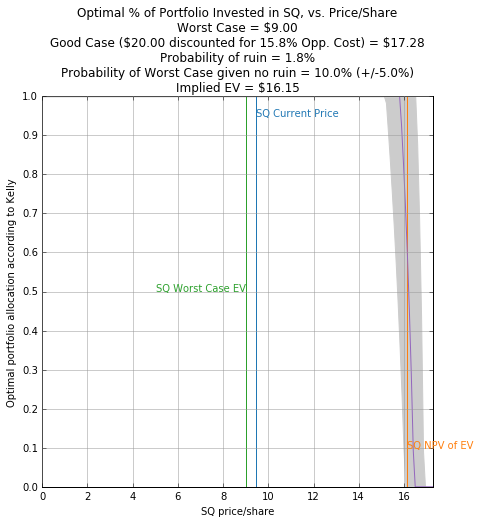

In [12]:
rcParams['figure.figsize'] = (7,7)
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#CFECF9', '#7F7F7F', '#BCBD22', '#17BECF']

plt.ylabel('Optimal portfolio allocation according to Kelly')
plt.xlabel('SQ price/share')
plt.axis([0, EV_GOOD, 0, 1])
plt.yticks(np.arange(0, 1.01, 0.1))
plt.grid(b=True, which='major', color='#999999', linestyle='-')

plt.annotate('SQ Current Price', xy=(CURRENT_PRICE, 0.95), color=colors[0])
plt.axvline(x=CURRENT_PRICE, ymin=0, ymax=1, color=colors[0])

plt.annotate('SQ NPV of EV', xy=(EV, 0.1), color=colors[1])
plt.axvline(x=EV, ymin=0, ymax=1, color=colors[1])

plt.annotate('SQ Worst Case EV', xy=(EV_WORST, 0.5), color=colors[2], horizontalalignment='right')
plt.axvline(x=EV_WORST, ymin=0, ymax=1, color=colors[2])

x = np.linspace(0, EV_GOOD, 201)

bet_size_worst = lambda price, p_up: kelly_bet_size_using_ev(EV_GOOD, p_up, EV_WORST, price)
bet_size_ruin = lambda price: kelly_bet_size_using_ev(EV_NORUIN, 1-P_RUIN, 0.0, price)
#y_base_f = lambda p_up=(1-P_WORST): [bet_size_worst(x_, p_up) * bet_size_ruin(x_) for x_ in x]
y_base_f = lambda p_up=(1-P_WORST): [bet_size_worst(x_, p_up) for x_ in x]

y_base = y_base_f()
plt.plot(x, y_base, color=colors[4],)

y_lo = y_base_f(p_up=(1-(P_WORST+P_WORST_ERROR)))
y_hi = y_base_f(p_up=(1-(P_WORST-P_WORST_ERROR)))

plt.fill_between(x, y_lo, y_hi, color='#cccccc')

title = (
    'Optimal % of Portfolio Invested in SQ, vs. Price/Share'
    + '\nWorst Case = ' + '\${0:.2f}'.format(EV_WORST)
    + '\nGood Case (\${0:.2f}'.format(EV_GOOD * (1.0+OPP_COST)) + ' discounted for {0:.1f}% Opp. Cost) = '.format(OPP_COST * 100) + '\${0:.2f}'.format(EV_GOOD)
    + '\nProbability of ruin = ' + '{0:.1f}%'.format(P_RUIN * 100)
    + '\nProbability of Worst Case given no ruin = ' + '{0:.1f}%'.format(P_WORST * 100) + ' (+/-{0:.1f}%)'.format(P_WORST_ERROR * 100)
    + '\nImplied EV = ' + '\${0:.2f}'.format(EV)
    )
plt.title(title)
plt.show()